# Regression

We're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, age, sex, bmi, children, smoking_status and residential_region.

Steps covered:
1. Import Libraries
2. Downloading and View Dataset
3. Minimal EDA
4. Data Preprocessing --- Splitting, Normalization, One hot encoding and K-fold Cross Validation
5. Model Building and Training with L1 regularizers
6. Model Evaluation and Prediction
7. Gradio App


In [27]:
#!pip install -q gradio

## Import libraries

In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

2.11.0


## Downloading and View Dataset

In [2]:
insurance = pd.read_csv("machine-learning-with-R-datasets/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Minimal EDA

Let's first visualize the histogram of medical costs.

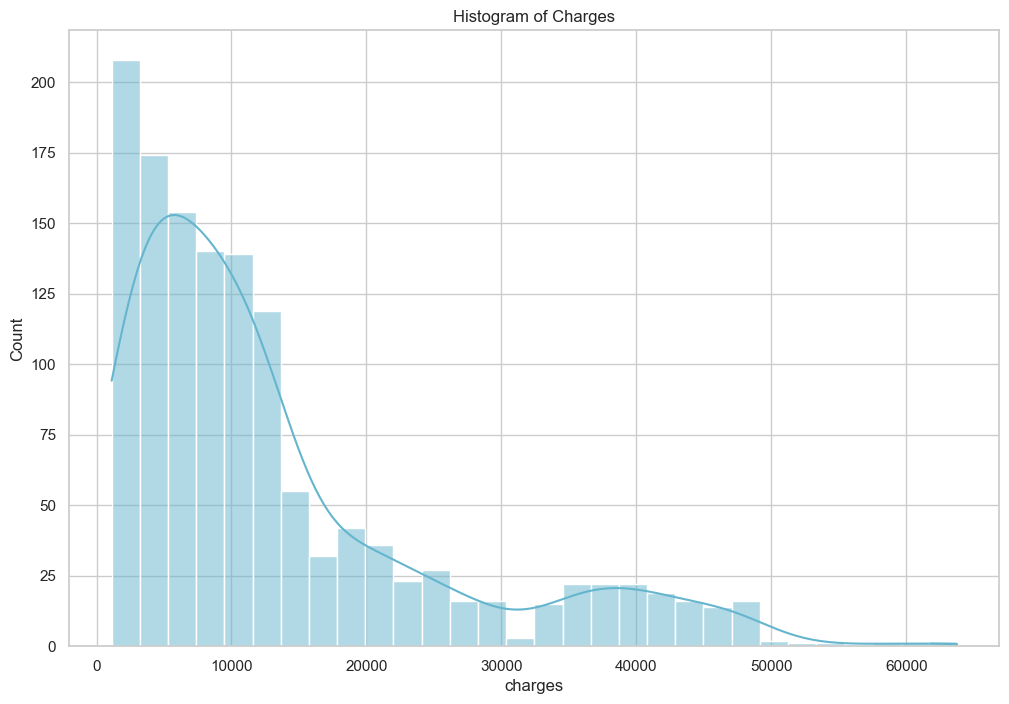

In [5]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.histplot(insurance['charges'], kde = True, color = 'c')
plt.title('Histogram of Charges')
plt.show()

This distribution is right-skewed. Let's guess that smoking might be most important factor on medical costs above region, age and bmi.

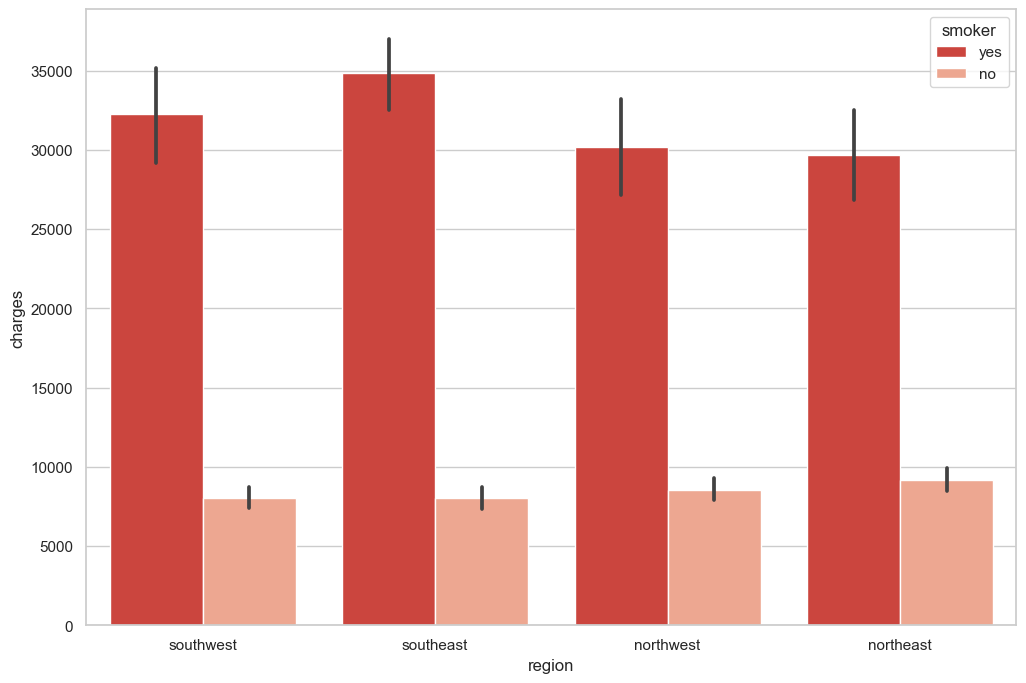

In [6]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=insurance, palette='Reds_r')

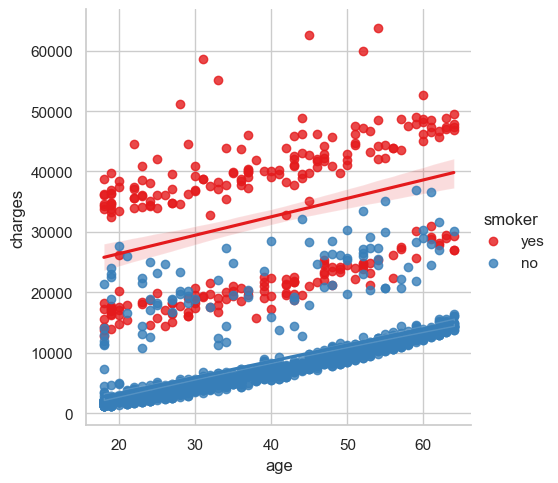

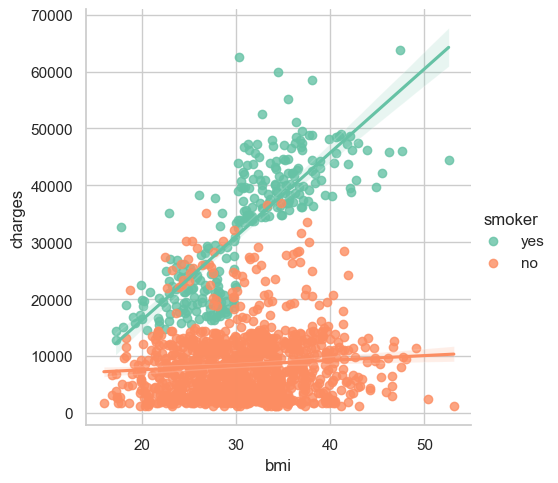

In [7]:
ax = sns.lmplot(x = 'age', y = 'charges', data=insurance, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=insurance, hue='smoker', palette='Set2')

Our guess seems right!!

## Data Preprocessing --- Splitting, Normalization and One hot encoding

We will convert categorical variables (like the sex, smoker and region columns) into numerical variables using one-hot encoding. We'll also be normalizing the numerical columns to make sure they're all between a range.

In [8]:
np.random.seed(101)

# Column transformer
ct = make_column_transformer(
    (StandardScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

print(X_train_normal[0])

[-1.15786012 -0.68882801 -0.92785237  0.          1.          1.
  0.          0.          0.          1.          0.        ]


In [9]:
print(X_train_normal.shape)
print(X_test_normal.shape)

(1070, 11)
(268, 11)


**As the number of training samples are low, we shall use K-fold cross validation technique to reduce overfitting**

In [10]:
# Merge inputs and targets
inputs = np.concatenate((X_train_normal, X_test_normal), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
print(inputs[0])

[-1.15786012 -0.68882801 -0.92785237  0.          1.          1.
  0.          0.          0.          1.          0.        ]


In [11]:
# Define the K-fold Cross Validator
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

## Model Building and Training

In [12]:
tf.random.set_seed(101)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model training and evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model = tf.keras.Sequential([
                                tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_normal.shape[1],)),
                                tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l1'),
                                tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l1'),
                                tf.keras.layers.Dense(1)
    ])
    # compile the model
    model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    #model.summary()
    #checkpointer
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f"bestmodel_{fold_no}.h5", verbose=0, mode='min',
                               save_best_only=True, monitor="loss")
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X_train_normal, y_train, epochs=50, callbacks=[checkpointer], verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 14.181108474731445; root_mean_squared_error of 7219.80712890625
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 12.459680557250977; root_mean_squared_error of 6696.02099609375
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 15.365432739257812; root_mean_squared_error of 7986.896484375
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 14.118884086608887; root_mean_squared_error of 7538.2001953125
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 14.072558403015137; root_mean_squared_error of 6199.05517578125
--------------------------------------------------------------------

### Plot Training Loss History

In [13]:
# == Provide average scores ==
print('Average scores for all folds:')
print(f'RMSE: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'Loss: {np.mean(loss_per_fold)}')

Average scores for all folds:
RMSE: 6781.664306640625 (+- 771.0499820035467)
Loss: 13.035519218444824


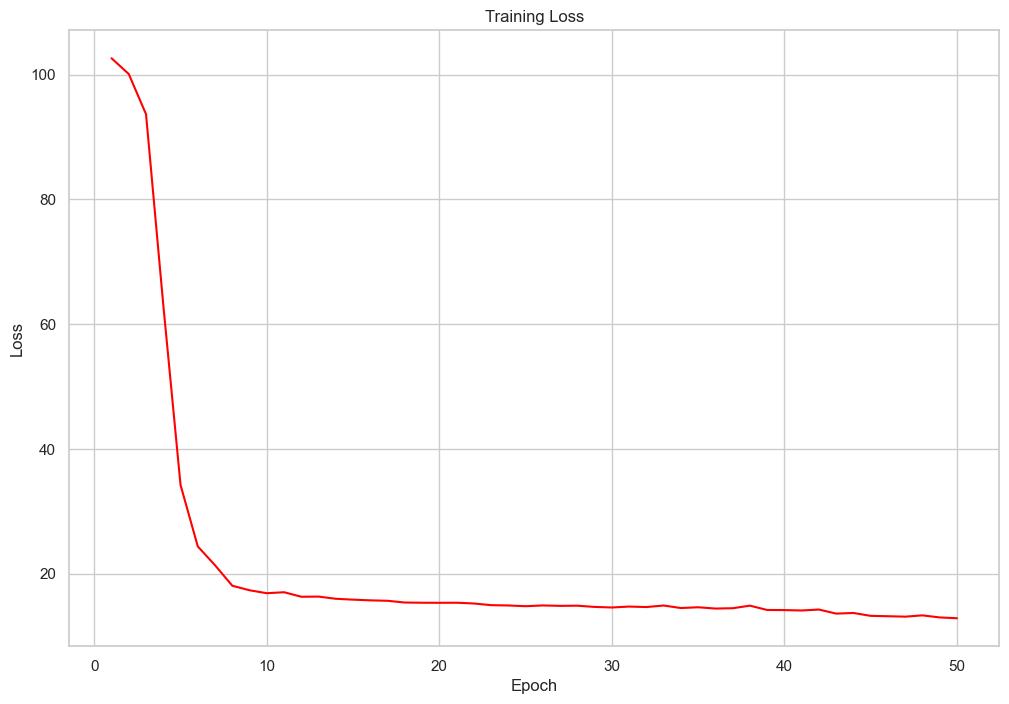

In [14]:
# summarize history for loss for last fold
plt.figure(figsize=(12,8))
plt.plot(range(1,len(history.history['loss'])+1), history.history['loss'], color="red")
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Model Evaluation and Prediction

In [15]:
# Evaluation for fold with lowest RMSE
bestmodel = tf.keras.models.load_model("bestmodel_2.h5")
score= bestmodel.evaluate(X_test_normal, y_test, verbose=0)
print("Minimal Training RMSE Score : ", score[1])

Minimal Training RMSE Score :  6633.5361328125


In [16]:
y_pred = bestmodel.predict(tf.expand_dims(X_test_normal[17], axis=0))
print(f"Pred Value: {y_pred[0][0]} \nGround Truth: {np.array(y_test)[17]}")

1/1 [==============================] - 0s 132ms/step
Pred Value: 4394.564453125 
Ground Truth: 4391.652


**So Close!!**

Let's visualize the deviation of predictions from complete test ground truth data.

9/9 [==============================] - 0s 2ms/step


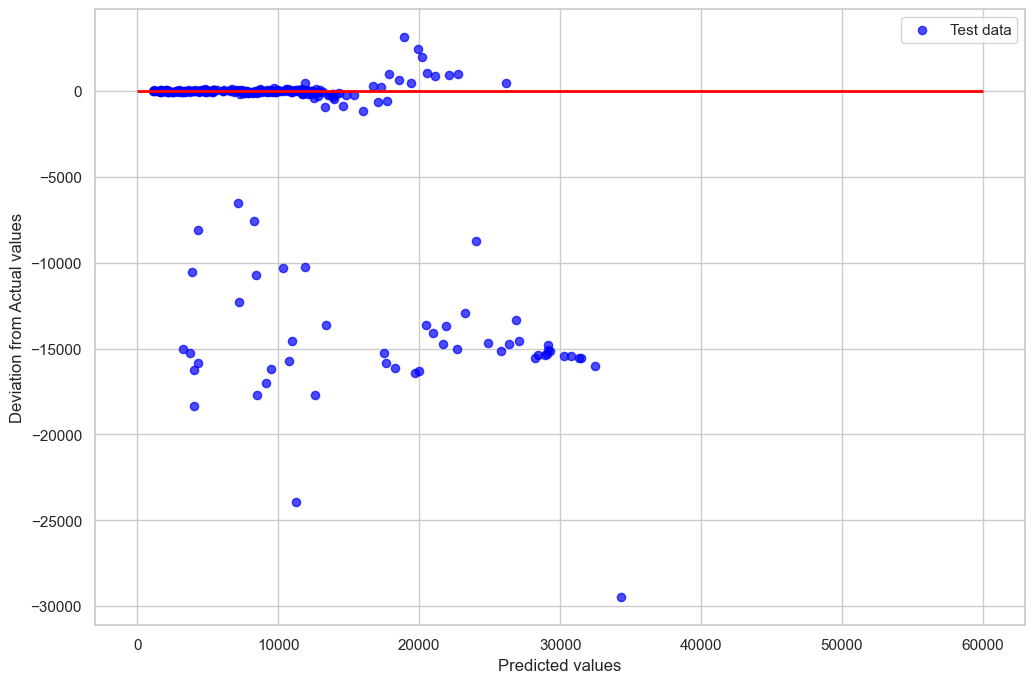

In [17]:
plt.figure(figsize=(12,8))
preds = bestmodel.predict(X_test_normal)
truth = np.asarray(y_test).reshape(-1,1)
plt.scatter(preds, preds - truth,
          c = 'blue', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Deviation from Actual values')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

**Our model did not do well for higher values. For medical costs less than 15K it did excellent job.**

## Gradio App

In [18]:
def predict(age, sex, bmi, children, smoker, region):
    smoker='yes' if smoker==True else 'no'
    df = pd.DataFrame(np.array([[age, sex, bmi, children, smoker, region]]),
                    columns=['age', 'sex', 'bmi','children', 'smoker', 'region'])
    data = ct.transform(df)
    y_pred = bestmodel.predict(tf.expand_dims(data[0], axis=0))
    return f"""Medical Cost: {str(y_pred.flatten()[0])}"""

In [19]:
face = gr.Interface(fn=predict, 
                    inputs=[
                            gr.inputs.Slider(18, 80, step=1), 
                            gr.inputs.Radio(["male", "female"]),
                            gr.inputs.Slider(15, 60, step=0.001),
                            gr.inputs.Slider(0, 5, step=1),
                            gr.inputs.Checkbox(label="Is the person a smoker?"),
                            gr.inputs.Dropdown(["northeast", "northwest", "southeast", "southwest"]),
                            ],
                    title = "Medical Insurance Cost Prediction",
                    description = "We're going to predict the cost of medical insurance for an individual based on the parameters",
                    outputs=["text"])
face.launch(debug=False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
